# Coursework2: Convolutional Neural Networks 

## instructions

Please submit a version of this notebook containing your answers **together with your trained model** on CATe as CW2.zip. Write your answers in the cells below each question.

A PDF version of this notebook is also provided in case the figures do not render correctly.

**The deadline for submission is 19:00, Thu 14th February, 2019**

### Setting up working environment 

For this coursework you will need to train a large network, therefore we recommend you work with Google Colaboratory, which provides free GPU time. You will need a Google account to do so. 

Please log in to your account and go to the following page: https://colab.research.google.com. Then upload this notebook.

For GPU support, go to "Edit" -> "Notebook Settings", and select "Hardware accelerator" as "GPU".

You will need to install pytorch by running the following cell:

In [0]:
!pip install torch torchvision

    100% |████████████████████████████████| 2.0MB 10.4MB/s 
imgaug 0.2.8 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


## Introduction

For this coursework you will implement one of the most commonly used model for image recognition tasks, the Residual Network. The architecture is introduced in 2015 by Kaiming He, et al. in the paper ["Deep residual learning for image recognition"](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf). 
<br>

In a residual network, each block contains some convolutional layers, plus "skip" connections, which allow the activations to by pass a layer, and then be summed up with the activations of the skipped layer. The image below illustrates a building block in residual networks.

![resnet-block](https://github.com/ZheyuYe/460/blob/master/coursework/cw2/utils/resnet-block.png?raw=1)

Depending on the number of building blocks, resnets can have different architectures, for example ResNet-50, ResNet-101 and etc. Here you are required to build ResNet-18 to perform classification on the CIFAR-10 dataset, therefore your network will have the following architecture:

![resnet](https://github.com/ZheyuYe/460/blob/master/coursework/cw2/utils/resnet.png?raw=1)

## Part 1 (40 points)

In this part, you will use basic pytorch operations to define the 2D convolution and max pooling operation. 

### YOUR TASK

- implement the forward pass for Conv2D and MaxPool2D
- You can only fill in the parts which are specified as "YOUR CODE HERE"
- You are **NOT** allowed to use the torch.nn module and the conv2d/maxpooling functions in torch.nn.functional

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [0]:
class Conv2D(nn.Module):
    
    def __init__(self, inchannel, outchannel, kernel_size, stride, padding, bias = True):
        
        super(Conv2D, self).__init__()
        
        self.inchannel = inchannel
        self.outchannel = outchannel
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        
        self.weights = nn.Parameter(torch.Tensor(outchannel, inchannel, 
                                                 kernel_size, kernel_size))
        self.weights.data.normal_(-0.1, 0.1)
        self.weights = nn.init.kaiming_normal(self.weights)
#         print("weights",self.weights.shape)
        
        if bias:
            self.bias = nn.Parameter(torch.Tensor(outchannel, ))
            self.bias.data.normal_(-0.1, 0.1)
            self.bias = nn.init.kaiming_normal(self.bias)
          
        else:
            self.bias = None
            
        
    def forward(self, x):
        
        ##############################################################
        #                       YOUR CODE HERE                       #       
        ##############################################################
#         print("input",x.shape) ##64,3,32,32
        self.batch_size = x.shape[0]
        inchannel = x.shape[1]
        input_size = x.shape[2]     
        output_size = int((input_size - self.kernel_size + 2*self.padding)/self.stride) + 1
#         output = torch.Tensor(self.batchsize,self.outchannel,outsize,outsize)
        inp_unf = F.unfold(x,self.kernel_size, dilation=1, padding=self.padding, stride=self.stride)
#         print("batch_size",batch_size)
#         print("input_size",input_size)
#         print("out_size",out_size)
#         print("inp_unf",inp_unf.shape)

#         print(inp_unf.transpose(1, 2).shape)
#         print(self.weights.view(outchannel, -1).shape)
        out_unf = inp_unf.transpose(1, 2) @ self.weights.view(self.outchannel, -1).transpose(1, 0)
        if self.bias != None:
            out_unf += self.bias
        output = out_unf.transpose(1,2).view(self.batch_size, self.outchannel, output_size, output_size)
#         print("after convolution",output.shape)
        ##############################################################
        #                       END OF YOUR CODE                     #
        ##############################################################

        return output
        

In [0]:
class MaxPool2D(nn.Module):
    
    def __init__(self, pooling_size):
        # assume pooling_size = kernel_size = stride
        
        super(MaxPool2D, self).__init__()
        
        self.pooling_size = pooling_size
        

    def forward(self, x):
        
        
        ##############################################################
        #                       YOUR CODE HERE                       #       
        ##############################################################
        pooling_size = 2
        input_size = x.shape[3]
        output_size = int((input_size-self.pooling_size)/self.pooling_size)+1
        inp_unf = F.unfold(x,self.pooling_size,stride=self.pooling_size).transpose(2,1)
        inp_unf = inp_unf.view(x.shape[0],-1,x.shape[1],self.pooling_size**2).transpose(2,1)
#         print("",inp_unf.shape)
        output=torch.max(inp_unf,3)[0].view(x.shape[0],x.shape[1],output_size,output_size)
#         print("after max pooling",output.shape)
#         diff = F.max_pool2d(x,self.pooling_size,self.pooling_size)-output
#         print(torch.norm(diff))


        ##############################################################
        #                       END OF YOUR CODE                     #
        ##############################################################
      
        return output
        

In [0]:
# define resnet building blocks

class ResidualBlock(nn.Module): 
    def __init__(self, inchannel, outchannel, stride=1): 
        
        super(ResidualBlock, self).__init__() 
        
        self.left = nn.Sequential(Conv2D(inchannel, outchannel, kernel_size=3, 
                                         stride=stride, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel), 
                                  nn.ReLU(inplace=True), 
                                  Conv2D(outchannel, outchannel, kernel_size=3, 
                                         stride=1, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel)) 
        
        self.shortcut = nn.Sequential() 
        
        if stride != 1 or inchannel != outchannel: 
            
            self.shortcut = nn.Sequential(Conv2D(inchannel, outchannel, 
                                                 kernel_size=1, stride=stride, 
                                                 padding = 0, bias=False), 
                                          nn.BatchNorm2d(outchannel) ) 
            
    def forward(self, x): 
        
        out = self.left(x) 
        
        out += self.shortcut(x) 
        
        out = F.relu(out) 
        
        return out


In [0]:
# define resnet

class ResNet(nn.Module):
    
    def __init__(self, ResidualBlock, num_classes = 10):
        
        super(ResNet, self).__init__()
        
        self.inchannel = 64
        self.conv1 = nn.Sequential(Conv2D(3, 64, kernel_size = 3, stride = 1,
                                            padding = 1, bias = False), 
                                  nn.BatchNorm2d(64), 
                                  nn.ReLU())
        
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride = 1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride = 2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride = 2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride = 2)
        self.maxpool = MaxPool2D(4)
        self.fc = nn.Linear(512, num_classes)
        
    
    def make_layer(self, block, channels, num_blocks, stride):
        
        strides = [stride] + [1] * (num_blocks - 1)
        
        layers = []
        
        for stride in strides:
            
            layers.append(block(self.inchannel, channels, stride))
            
            self.inchannel = channels
            
        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        
        x = self.conv1(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.maxpool(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        
        return x
    
    
def ResNet18():
    return ResNet(ResidualBlock)

## Part 2 (40 points)

In this part, you will train the ResNet-18 defined in the previous part on the CIFAR-10 dataset. Code for loading the dataset, training and evaluation are provided. 

### Your Task

1. Train your network to achieve the best possible test set accuracy after a maximum of 10 epochs of training.

2. You can use techniques such as optimal hyper-parameter searching, data pre-processing

3. If necessary, you can also use another optimiser

4. **Answer the following question:**
Given such a network with a large number of trainable parameters, and a training set of a large number of data, what do you think is the best strategy for hyperparameter searching? 


**YOUR ANSWER FOR 2.4 HERE**

A:

There are serveal hyper-parameters optimization methods such as Grid Search, Random Serach, Babysitting, Bayesian Optimization, etc. 
* Compared to Grid Search which the time complexity will skyrocket as the parameter dimension grows,  random search provides a more efficient solution (especially in the case of a large number of parameters). Random Search defines a distribution function for each parameter and samples it in a specific range.
* Bayesian Optimization builds a probabilistic proxy model that attempts to predict the objective function value that we care about based on the hyperparameters. Expected Improvement was used to determine the uncertain area.

It is hard to say which one is the best strategy for hyperparameter searching. Grid Search and Random Search is the two most practical and efficient methods, and for small number of hyperparameter(less than 3 or 4), I would like to say Grid Search is good enough. When suitation becoms to complex, Bayesian Optimization might be a good method to find best hyperparameters which is both good at time complexity and efficient.

In [0]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset

import numpy as np

import torchvision.transforms as T


#     define transforms for normalization and data augmentation
transform_augment = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomCrop(32, padding=4)])
transform_normalize = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


# load data

NUM_TRAIN = 49000
print_every = 100


data_dir = './data'
cifar10_train = dset.CIFAR10(data_dir, train=True, download=True, transform=T.Compose([transform_augment, transform_normalize]))
loader_train = DataLoader(cifar10_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10(data_dir, train=True, download=True, transform=transform_normalize)
loader_val = DataLoader(cifar10_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10(data_dir, train=False, download=True, transform=transform_normalize)
loader_test = DataLoader(cifar10_test, batch_size=64)


USE_GPU = True
dtype = torch.float32 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

Files already downloaded and verified
Files already downloaded and verified


In [0]:
from time import time
def check_accuracy(loader, model):
    # function for test accuracy on validation and test set
    
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    
    return 100*acc

def train_part(loader,model, optimizer, epochs =1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
#         print(len(loader))
        for t, (x, y) in enumerate(loader):
            t0 = time()
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            loss.backward()

            # Update the parameters of the model using the gradients
            optimizer.step()
            if len(loader) == len(loader_train):
                if t % print_every == 0:
                    t1 = time()
                    print('_Train_ Epoch: %d, Iteration %d, loss = %.4f, time = %.4f s' % (e, t, loss.item(),t1-t0))
#                     check_accuracy(loader_val, model)
            else:
                if t == 15 and e == epochs-1:
                    t1 = time()
                    print('_Search_, loss = %.4f, time = %.4f s' % (loss.item(),t1-t0))
                

In [0]:
## Part 3 (20 points)

To optimise the network the following methods are used :
1. **Data pre-processing**  including data augmentation, normalization and standardization.
2. **BayesianOptimization**  here  external libraries GPY(1.9.6) and GPYOPT(4.3.2) are used, the documents  of GPYOPT can be found in http://github.com/SheffieldML/GPyOpt.  Bayesian Optimization method is used to search the best hyper-parameters which are learning rate and weight decay, in the range of (1e-4,3e-2) and (1e-4,1e-2) respectively. validation set is choosed as our search space to find  best hyper-parameters, and use the accuracy of validation set as objective function which we need to maximize.

In [0]:
!pip install gpy
!pip install gpyopt


    100% |████████████████████████████████| 880kB 12.2MB/s 
    100% |████████████████████████████████| 71kB 24.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/97/82/1d/32a361e1ff2b4d9129a60343831dd99cdc74440e2db1c55264
  Stored in directory: /root/.cache/pip/wheels/a9/fc/74/3bbd263c43ed98d67343df24cebf0a0ee34afee40d769fda9c
Successfully built gpy paramz
    100% |████████████████████████████████| 61kB 2.3MB/s 
  Stored in directory: /root/.cache/pip/wheels/33/1d/87/dc02440831ba986b1547dd11a7dcd44e893b0527083066d869
Successfully built gpyopt


_Search_, loss = 1.9419, time = 0.2323 s
Checking accuracy on validation set
Got 207 / 1000 correct (20.70)
_Search_, loss = 1.9401, time = 0.2322 s
Checking accuracy on validation set
Got 170 / 1000 correct (17.00)
_Search_, loss = 1.9647, time = 0.2321 s
Checking accuracy on validation set
Got 285 / 1000 correct (28.50)
_Search_, loss = 1.5618, time = 0.2377 s
Checking accuracy on validation set
Got 283 / 1000 correct (28.30)
_Search_, loss = 1.6822, time = 0.2346 s
Checking accuracy on validation set
Got 252 / 1000 correct (25.20)
_Search_, loss = 0.0189, time = 0.2368 s
Checking accuracy on validation set
Got 1000 / 1000 correct (100.00)
_Search_, loss = 0.0166, time = 0.2380 s
Checking accuracy on validation set
Got 1000 / 1000 correct (100.00)


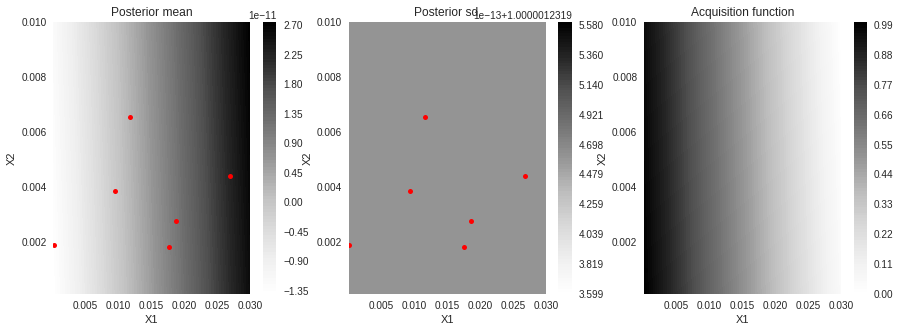

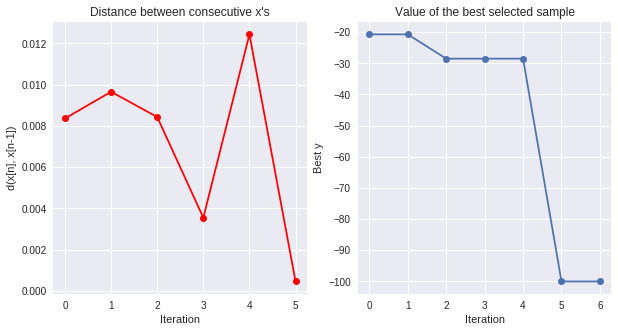

Best Hyperparameter with Learning Rate = 0.000182, Weight Decay = 0.001881, Accuracy: -100.00
_Train_ Epoch: 0, Iteration 0, loss = 2.7921, time = 0.3020 s
_Train_ Epoch: 0, Iteration 100, loss = 1.6605, time = 0.3250 s
_Train_ Epoch: 0, Iteration 200, loss = 1.3712, time = 0.3269 s
_Train_ Epoch: 0, Iteration 300, loss = 1.6227, time = 0.3245 s
_Train_ Epoch: 0, Iteration 400, loss = 1.4002, time = 0.3264 s
_Train_ Epoch: 0, Iteration 500, loss = 1.3063, time = 0.3249 s
_Train_ Epoch: 0, Iteration 600, loss = 1.1409, time = 0.3267 s
_Train_ Epoch: 0, Iteration 700, loss = 1.2066, time = 0.3235 s
_Train_ Epoch: 1, Iteration 0, loss = 1.1418, time = 0.3017 s
_Train_ Epoch: 1, Iteration 100, loss = 1.1263, time = 0.3274 s
_Train_ Epoch: 1, Iteration 200, loss = 1.0776, time = 0.3251 s
_Train_ Epoch: 1, Iteration 300, loss = 0.9792, time = 0.3233 s
_Train_ Epoch: 1, Iteration 400, loss = 1.1839, time = 0.3253 s
_Train_ Epoch: 1, Iteration 500, loss = 1.1044, time = 0.3252 s
_Train_ Epoch:

In [0]:
# code for optimising your network performance

##############################################################
#                       YOUR CODE HERE                       #       
##############################################################
import GPy
import GPyOpt

def Bayesian_Optimization(paras):
    model = ResNet18()
    
    paras=paras.squeeze()
    optimizer = optim.Adam(model.parameters(),lr=paras[0],weight_decay=paras[1])
#     random  = int(torch.rand(1)*48000)
#     print("Random train batch: %d-%d Learning, Rate = %.6f, Weight Decay = %.6f"%(random,random+1000,paras[0],paras[1]))
#     loader_random = DataLoader(cifar10_train, batch_size=64, 
#                         sampler=sampler.SubsetRandomSampler(range(random, random+1000)))
    train_part(loader_val,model,optimizer,epochs = 10)
    return check_accuracy(loader_val, model)
  
bounds = [{'name': 'learning_rate', 'type': 'continuous', 'domain': (1e-4,3e-2)},
          {'name': 'weight_decay', 'type': 'continuous', 'domain': (1e-4,1e-2)}]
BO_test = GPyOpt.methods.BayesianOptimization(f=Bayesian_Optimization,# function to optimize       
                                             domain=bounds,        # box-constraints of the problem
                                             model_type = 'GP',
                                             acquisition_type='EI',
                                             maximize = True)
max_iter = 20    # evaluation budget
max_time = 60     # time budget 
eps      = 10e-6  # Minimum allows distance between the las two observations

BO_test.run_optimization(max_iter, max_time,eps)
BO_test.plot_acquisition()
BO_test.plot_convergence()
learning_rate, weight_decay= BO_test.x_opt
print("Best Hyperparameter with Learning Rate = %.6f, Weight Decay = %.6f, Accuracy: %.2f"%(learning_rate,weight_decay,BO_test.fx_opt))

##############################################################
#                       END OF YOUR CODE                     #
##############################################################

model = ResNet18()
# define and train the network
optimizer = optim.Adam(model.parameters(),lr=learning_rate,weight_decay=weight_decay)
train_part(loader_train, model, optimizer, epochs = 10)

# report test set accuracy
check_accuracy(loader_test, model)

# save the model
torch.save(model.state_dict(), 'model.pt')

In [14]:
# load the model
model = ResNet18()
model.load_state_dict(torch.load('model.pt'))
model = model.to(device=device)
model.eval()

# report test set accuracy
check_accuracy(loader_test, model)

Checking accuracy on test set
Got 8357 / 10000 correct (83.57)


83.57

The code provided below will allow you to visualise the feature maps computed by different layers of your network. Run the code (install matplotlib if necessary) and **answer the following questions**: 

1. Compare the feature maps from low-level layers to high-level layers, what do you observe? 

2. Use the training log, reported test set accuracy and the feature maps, analyse the performance of your network. If you think the performance is sufficiently good, explain why; if not, what might be the problem and how can you improve the performance?

3. What are the other possible ways to analyse the performance of your network?

**YOUR ANSWER FOR PART 3 HERE**

A: 
1. From low-level layers to high-level layers, the size of channels increases from 3 channels respect to RGB colours to 512 channels at the end. In this process, the receptive field  of each value in feature maps is bigger which means it corresponses larger range in the orginal images. At same time, the size of input decrease from 32*32 and it maps to the number of classes at the end.
2. Data augmentation techniques such as ﬂip, randomcrop are used to increase the size of training data which improve the performance of this Residual Network. Bayesian optimization, which is a efﬁcient and fast way to search the best hyper-parameters, is used in this newtork, and it perform good results within only around half an hour of training session. At the end of our training, we get **83.57** pencentage of accuracy on test set. It seems not good enough due to the limited epoch and fixed batch size.
The following methods can be used to improve the performance of this newtork:
 *  Get more date with the help of data augmentation mentioned in pervious.
 *  reconstructe this network or tuning neural network algorithm with activation and loss functions and we can adjust the  batch and epoch size to get better performance.
 * Adjust the number of features manually or use less number of hidden units
 * Adding regularizers such as L1 / L2 weight regularization or Max-Norm regularization
 * Early Stopping to reduce time complexity 
3. In this network, the accuracy is the only measurement to analyse the performance. While sometimes, computation and time complexity are also quiet important to check the network is good or not due to dynamics of information.  

<Figure size 576x396 with 0 Axes>

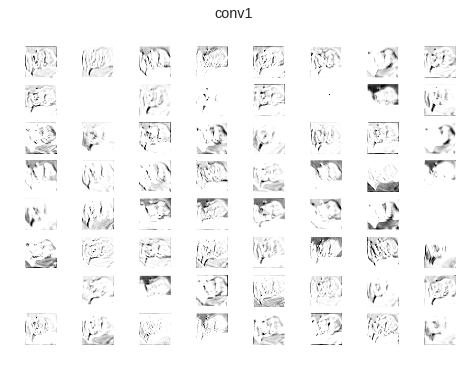

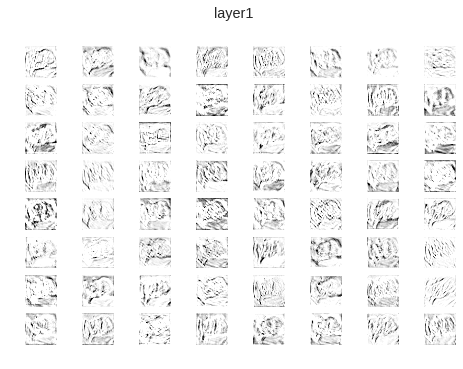

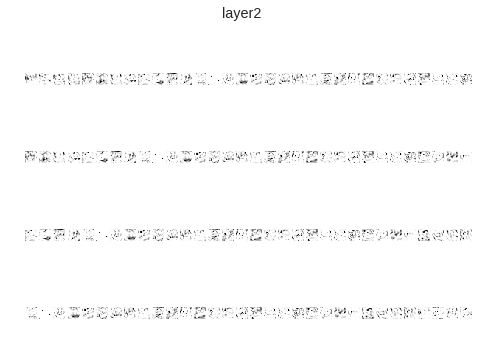

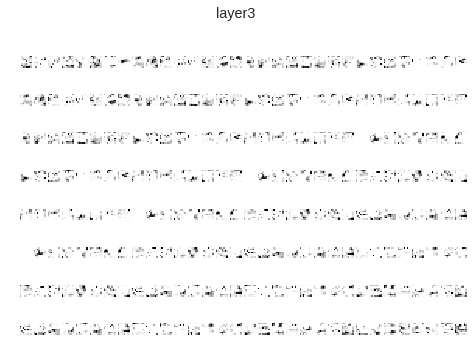

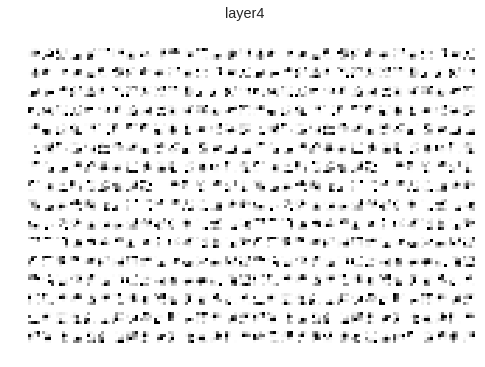

In [13]:
#!pip install matplotlib

import matplotlib.pyplot as plt


plt.tight_layout()


activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

vis_labels = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4']

for l in vis_labels:

    getattr(model, l).register_forward_hook(get_activation(l))
    
    
data, _ = cifar10_test[0]
data = data.unsqueeze_(0).to(device = device, dtype = dtype)

output = model(data)



for idx, l in enumerate(vis_labels):

    act = activation[l].squeeze()

    if idx < 2:
        ncols = 8
    else:
        ncols = 32
        
    nrows = act.size(0) // ncols
    
    fig, axarr = plt.subplots(nrows, ncols)
    fig.suptitle(l)


    for i in range(nrows):
        for j in range(ncols):
            axarr[i, j].imshow(act[i * nrows + j].cpu())
            axarr[i, j].axis('off')

**=============== END OF CW2 ===============**